In [1]:
import pandas as pd

train_df = pd.read_csv("train_critic.csv").dropna()  # Carregando dados de treino
train_df = train_df.groupby('Sentiment', group_keys=False).apply(lambda x: x.sample(1500)).reset_index(drop=True)

/tmp/ipykernel_36988/1962648338.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby('Sentiment', group_keys=False).apply(lambda x: x.sample(1500)).reset_index(drop=True)


In [ ]:
from transformers import AutoTokenizer, Trainer, Trainer, TrainingArguments, AutoModelForSequenceClassification
import torch

NUM_LABELS = 2  # Número de classes
model_name = "google-bert/bert-base-uncased"  # Escolha o modelo conforme sua necessidade
tokenizer = AutoTokenizer.from_pretrained(model_name)  # Carregar o tokenizer
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS)  # Carregar o modelo de classificação

/home/felipedias/BigData/Trabalho1/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-23 13:06:17.446541: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-23 13:06:17.453432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732377977.462091   36988 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732377977.464678   36988 cuda_bla

In [3]:
from datasets import Dataset
import tensorflow as tf
import random
import numpy as np
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)


train_data_set = Dataset.from_pandas(train_df)
train_val_set = train_data_set.train_test_split (test_size = 0.2)

print(train_val_set)

x_train = train_val_set["train"]["Review"]
x_val = train_val_set["test"]["Review"]
y_train = train_val_set["train"]["Sentiment"]
y_val = train_val_set["test"]["Sentiment"] 


DatasetDict({
    train: Dataset({
        features: ['Show', 'Sentiment', 'Review'],
        num_rows: 2400
    })
    test: Dataset({
        features: ['Show', 'Sentiment', 'Review'],
        num_rows: 600
    })
})


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

def  plot_loss_accuracy(df):
    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    sns.lineplot(data=df[['loss', 'eval_loss']])

In [5]:
from sklearn import metrics

def plot_confusion_matrix(dataset, predictions, labels=None):
    #calcula a acurácia balanceada
    labels = dataset['Sentiment']
    preds = [0 if pred['label'] == 'LABEL_0' else 1 for pred in predictions]
    
    
    print('balanced Accuracy:', balanced_accuracy_score(labels, preds))
    print('accuracy', metrics.accuracy_score(labels, preds))

    # Calculo da matriz de confusão.
    c = metrics.confusion_matrix(labels, preds)
    r = c / c.sum(axis=1, keepdims=True)

    plt.figure(figsize=(10, 8))
    sns.heatmap(r, annot=True, fmt=".2f", cmap="Blues")
    plt.xlabel("Classe predita")
    plt.ylabel("Classe verdadeira")
    plt.title("Matriz de confusão relativa")
    plt.show()

In [6]:
train_encodings = tokenizer(list(x_train), truncation=True, padding=True, max_length=256)
valid_encodings = tokenizer(list(x_val), truncation=True, padding=True, max_length=256)

In [7]:
class DatasetLoader(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = DatasetLoader(train_encodings, list(y_train))
valid_dataset = DatasetLoader(valid_encodings, list(y_val))

In [8]:
training_args = TrainingArguments(
per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=35,
    logging_dir='./logs1',
    logging_steps=200,
    evaluation_strategy="steps",
    eval_steps=200,
    output_dir='./results1',
    learning_rate=0.00001,
    lr_scheduler_type="constant",
    remove_unused_columns=False,
)


/home/felipedias/BigData/Trabalho1/.venv/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [9]:
def make_model_contiguous(model):
    # Aplica .contiguous() a todos os tensores dos parâmetros do modelo
    for param in model.parameters():
        if not param.is_contiguous():
            param.data = param.data.contiguous()

In [10]:
from sklearn.metrics import balanced_accuracy_score

def compute_metrics(p):
    return {"balanced_accuracy": balanced_accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))}

In [11]:


make_model_contiguous(model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

In [12]:
trainer.train()

  4%|▍         | 200/5250 [00:01<00:23, 219.33it/s]

{'loss': 0.6905, 'grad_norm': 2.375555992126465, 'learning_rate': 1e-05, 'epoch': 1.33}


                                                   
  4%|▍         | 228/5250 [00:01<00:25, 195.73it/s]

{'eval_loss': 0.6852754950523376, 'eval_balanced_accuracy': 0.5737925115091795, 'eval_runtime': 0.0418, 'eval_samples_per_second': 14365.613, 'eval_steps_per_second': 454.911, 'epoch': 1.33}


  8%|▊         | 400/5250 [00:02<00:21, 222.45it/s]

{'loss': 0.6784, 'grad_norm': 1.9524530172348022, 'learning_rate': 1e-05, 'epoch': 2.67}


                                                   
  8%|▊         | 412/5250 [00:02<00:24, 197.11it/s]

{'eval_loss': 0.6773661375045776, 'eval_balanced_accuracy': 0.5889300085831168, 'eval_runtime': 0.041, 'eval_samples_per_second': 14639.634, 'eval_steps_per_second': 463.588, 'epoch': 2.67}


 11%|█▏        | 600/5250 [00:02<00:21, 214.83it/s]

{'loss': 0.666, 'grad_norm': 3.1333460807800293, 'learning_rate': 1e-05, 'epoch': 4.0}


                                                   
 12%|█▏        | 618/5250 [00:03<00:24, 190.80it/s]

{'eval_loss': 0.6730816960334778, 'eval_balanced_accuracy': 0.5968888987972489, 'eval_runtime': 0.0402, 'eval_samples_per_second': 14916.617, 'eval_steps_per_second': 472.36, 'epoch': 4.0}


 15%|█▌        | 800/5250 [00:03<00:19, 225.95it/s]

{'loss': 0.653, 'grad_norm': 3.440255641937256, 'learning_rate': 1e-05, 'epoch': 5.33}


                                                   
 16%|█▌        | 828/5250 [00:04<00:21, 206.66it/s]

{'eval_loss': 0.6728368401527405, 'eval_balanced_accuracy': 0.592792411187034, 'eval_runtime': 0.0411, 'eval_samples_per_second': 14595.568, 'eval_steps_per_second': 462.193, 'epoch': 5.33}


 19%|█▉        | 1000/5250 [00:04<00:18, 228.94it/s]

{'loss': 0.638, 'grad_norm': 2.6291284561157227, 'learning_rate': 1e-05, 'epoch': 6.67}


                                                    
 19%|█▉        | 1014/5250 [00:04<00:23, 183.09it/s]

{'eval_loss': 0.6507605910301208, 'eval_balanced_accuracy': 0.6117700170547646, 'eval_runtime': 0.0403, 'eval_samples_per_second': 14905.838, 'eval_steps_per_second': 472.018, 'epoch': 6.67}


 23%|██▎       | 1200/5250 [00:05<00:17, 225.00it/s]

{'loss': 0.6175, 'grad_norm': 4.581037998199463, 'learning_rate': 1e-05, 'epoch': 8.0}


                                                    
 23%|██▎       | 1225/5250 [00:05<00:19, 209.43it/s]

{'eval_loss': 0.6479892730712891, 'eval_balanced_accuracy': 0.6245220764454749, 'eval_runtime': 0.0398, 'eval_samples_per_second': 15060.788, 'eval_steps_per_second': 476.925, 'epoch': 8.0}


 27%|██▋       | 1400/5250 [00:06<00:17, 224.78it/s]

{'loss': 0.5926, 'grad_norm': 6.040822982788086, 'learning_rate': 1e-05, 'epoch': 9.33}


                                                    
 27%|██▋       | 1434/5250 [00:06<00:18, 204.53it/s]

{'eval_loss': 0.6332148909568787, 'eval_balanced_accuracy': 0.6420561581077013, 'eval_runtime': 0.0408, 'eval_samples_per_second': 14707.911, 'eval_steps_per_second': 465.751, 'epoch': 9.33}


 30%|███       | 1600/5250 [00:07<00:16, 214.84it/s]

{'loss': 0.5708, 'grad_norm': 3.953458786010742, 'learning_rate': 1e-05, 'epoch': 10.67}


                                                    
 31%|███       | 1615/5250 [00:07<00:18, 193.10it/s]

{'eval_loss': 0.6257117986679077, 'eval_balanced_accuracy': 0.6517706858690684, 'eval_runtime': 0.0402, 'eval_samples_per_second': 14915.909, 'eval_steps_per_second': 472.337, 'epoch': 10.67}


 34%|███▍      | 1800/5250 [00:08<00:15, 224.68it/s]

{'loss': 0.553, 'grad_norm': 6.059935092926025, 'learning_rate': 1e-05, 'epoch': 12.0}


                                                    
 35%|███▍      | 1821/5250 [00:08<00:17, 198.88it/s]

{'eval_loss': 0.6210017800331116, 'eval_balanced_accuracy': 0.6597853106085095, 'eval_runtime': 0.0401, 'eval_samples_per_second': 14972.438, 'eval_steps_per_second': 474.127, 'epoch': 12.0}


 38%|███▊      | 2000/5250 [00:09<00:14, 224.14it/s]

{'loss': 0.5261, 'grad_norm': 7.156562805175781, 'learning_rate': 1e-05, 'epoch': 13.33}


                                                    
 39%|███▊      | 2027/5250 [00:09<00:16, 193.13it/s]

{'eval_loss': 0.6186253428459167, 'eval_balanced_accuracy': 0.6636365663073648, 'eval_runtime': 0.0401, 'eval_samples_per_second': 14956.688, 'eval_steps_per_second': 473.628, 'epoch': 13.33}


 42%|████▏     | 2200/5250 [00:10<00:13, 222.80it/s]

{'loss': 0.5082, 'grad_norm': 3.5932669639587402, 'learning_rate': 1e-05, 'epoch': 14.67}


                                                    
 43%|████▎     | 2232/5250 [00:10<00:14, 205.79it/s]

{'eval_loss': 0.6162256598472595, 'eval_balanced_accuracy': 0.6690595356199351, 'eval_runtime': 0.0395, 'eval_samples_per_second': 15181.719, 'eval_steps_per_second': 480.754, 'epoch': 14.67}


 46%|████▌     | 2400/5250 [00:11<00:12, 224.16it/s]

{'loss': 0.4872, 'grad_norm': 7.247564315795898, 'learning_rate': 1e-05, 'epoch': 16.0}


                                                    
 46%|████▌     | 2418/5250 [00:11<00:14, 198.47it/s]

{'eval_loss': 0.6169452667236328, 'eval_balanced_accuracy': 0.6710158174582828, 'eval_runtime': 0.0421, 'eval_samples_per_second': 14253.25, 'eval_steps_per_second': 451.353, 'epoch': 16.0}


 50%|████▉     | 2600/5250 [00:12<00:12, 214.79it/s]

{'loss': 0.4596, 'grad_norm': 8.303200721740723, 'learning_rate': 1e-05, 'epoch': 17.33}


                                                    
 50%|████▉     | 2624/5250 [00:12<00:13, 196.58it/s]

{'eval_loss': 0.6191937327384949, 'eval_balanced_accuracy': 0.670887628050072, 'eval_runtime': 0.0604, 'eval_samples_per_second': 9937.539, 'eval_steps_per_second': 314.689, 'epoch': 17.33}


 53%|█████▎    | 2800/5250 [00:13<00:10, 224.59it/s]

{'loss': 0.4361, 'grad_norm': 7.314716339111328, 'learning_rate': 1e-05, 'epoch': 18.67}


                                                    
 54%|█████▍    | 2832/5250 [00:13<00:12, 200.71it/s]

{'eval_loss': 0.6273146271705627, 'eval_balanced_accuracy': 0.6783337606313606, 'eval_runtime': 0.0412, 'eval_samples_per_second': 14549.158, 'eval_steps_per_second': 460.723, 'epoch': 18.67}


 57%|█████▋    | 3000/5250 [00:14<00:10, 217.71it/s]

{'loss': 0.4296, 'grad_norm': 4.257877826690674, 'learning_rate': 1e-05, 'epoch': 20.0}


                                                    
 57%|█████▋    | 3008/5250 [00:14<00:12, 178.18it/s]

{'eval_loss': 0.6325631737709045, 'eval_balanced_accuracy': 0.6862870773929618, 'eval_runtime': 0.0414, 'eval_samples_per_second': 14505.55, 'eval_steps_per_second': 459.342, 'epoch': 20.0}


 61%|██████    | 3200/5250 [00:15<00:09, 221.66it/s]

{'loss': 0.4086, 'grad_norm': 17.705583572387695, 'learning_rate': 1e-05, 'epoch': 21.33}


                                                    
 61%|██████    | 3214/5250 [00:15<00:10, 198.28it/s]

{'eval_loss': 0.6339369416236877, 'eval_balanced_accuracy': 0.6860975800069111, 'eval_runtime': 0.0409, 'eval_samples_per_second': 14670.101, 'eval_steps_per_second': 464.553, 'epoch': 21.33}


 65%|██████▍   | 3400/5250 [00:16<00:08, 230.81it/s]

{'loss': 0.3701, 'grad_norm': 6.391138076782227, 'learning_rate': 1e-05, 'epoch': 22.67}


                                                    
 65%|██████▌   | 3429/5250 [00:16<00:08, 209.62it/s]

{'eval_loss': 0.6513808965682983, 'eval_balanced_accuracy': 0.6785232580174114, 'eval_runtime': 0.0453, 'eval_samples_per_second': 13258.499, 'eval_steps_per_second': 419.852, 'epoch': 22.67}


 69%|██████▊   | 3600/5250 [00:17<00:08, 188.22it/s]

{'loss': 0.3627, 'grad_norm': 12.04675006866455, 'learning_rate': 1e-05, 'epoch': 24.0}


                                                    
 69%|██████▉   | 3632/5250 [00:17<00:08, 192.06it/s]

{'eval_loss': 0.6604006886482239, 'eval_balanced_accuracy': 0.6826253190801574, 'eval_runtime': 0.0407, 'eval_samples_per_second': 14759.581, 'eval_steps_per_second': 467.387, 'epoch': 24.0}


 72%|███████▏  | 3800/5250 [00:18<00:06, 225.93it/s]

{'loss': 0.338, 'grad_norm': 5.505080223083496, 'learning_rate': 1e-05, 'epoch': 25.33}


                                                    
 73%|███████▎  | 3817/5250 [00:18<00:07, 200.87it/s]

{'eval_loss': 0.6800758838653564, 'eval_balanced_accuracy': 0.6917713546833721, 'eval_runtime': 0.041, 'eval_samples_per_second': 14644.831, 'eval_steps_per_second': 463.753, 'epoch': 25.33}


 76%|███████▌  | 4000/5250 [00:19<00:05, 218.06it/s]

{'loss': 0.3381, 'grad_norm': 11.166945457458496, 'learning_rate': 1e-05, 'epoch': 26.67}


                                                    
 77%|███████▋  | 4022/5250 [00:19<00:07, 173.60it/s]

{'eval_loss': 0.6812239289283752, 'eval_balanced_accuracy': 0.6865991907346924, 'eval_runtime': 0.0407, 'eval_samples_per_second': 14738.576, 'eval_steps_per_second': 466.722, 'epoch': 26.67}


 80%|████████  | 4200/5250 [00:20<00:04, 221.02it/s]

{'loss': 0.3142, 'grad_norm': 4.820121765136719, 'learning_rate': 1e-05, 'epoch': 28.0}


                                                    
 81%|████████  | 4229/5250 [00:20<00:05, 204.06it/s]

{'eval_loss': 0.7055336236953735, 'eval_balanced_accuracy': 0.6966927132681611, 'eval_runtime': 0.0411, 'eval_samples_per_second': 14598.108, 'eval_steps_per_second': 462.273, 'epoch': 28.0}


 84%|████████▍ | 4400/5250 [00:21<00:03, 220.60it/s]

{'loss': 0.3034, 'grad_norm': 11.71337604522705, 'learning_rate': 1e-05, 'epoch': 29.33}


                                                    
 84%|████████▍ | 4415/5250 [00:21<00:04, 196.05it/s]

{'eval_loss': 0.7065576314926147, 'eval_balanced_accuracy': 0.6973893948345242, 'eval_runtime': 0.0411, 'eval_samples_per_second': 14586.093, 'eval_steps_per_second': 461.893, 'epoch': 29.33}


 88%|████████▊ | 4600/5250 [00:22<00:02, 222.64it/s]

{'loss': 0.2706, 'grad_norm': 8.963889122009277, 'learning_rate': 1e-05, 'epoch': 30.67}


                                                    
 88%|████████▊ | 4622/5250 [00:22<00:03, 197.85it/s]

{'eval_loss': 0.7364423871040344, 'eval_balanced_accuracy': 0.6924680362497353, 'eval_runtime': 0.0399, 'eval_samples_per_second': 15039.727, 'eval_steps_per_second': 476.258, 'epoch': 30.67}


 91%|█████████▏| 4800/5250 [00:22<00:01, 225.83it/s]

{'loss': 0.2689, 'grad_norm': 17.187950134277344, 'learning_rate': 1e-05, 'epoch': 32.0}


                                                    
 92%|█████████▏| 4833/5250 [00:23<00:02, 205.41it/s]

{'eval_loss': 0.752210259437561, 'eval_balanced_accuracy': 0.6929752204300477, 'eval_runtime': 0.0412, 'eval_samples_per_second': 14559.343, 'eval_steps_per_second': 461.046, 'epoch': 32.0}


 95%|█████████▌| 5000/5250 [00:23<00:01, 210.62it/s]

{'loss': 0.2774, 'grad_norm': 25.0162410736084, 'learning_rate': 1e-05, 'epoch': 33.33}


                                                    
 96%|█████████▌| 5015/5250 [00:24<00:01, 174.73it/s]

{'eval_loss': 0.7654253840446472, 'eval_balanced_accuracy': 0.6946751234519736, 'eval_runtime': 0.0402, 'eval_samples_per_second': 14917.589, 'eval_steps_per_second': 472.39, 'epoch': 33.33}


 99%|█████████▉| 5200/5250 [00:24<00:00, 226.94it/s]

{'loss': 0.2474, 'grad_norm': 22.563600540161133, 'learning_rate': 1e-05, 'epoch': 34.67}


                                                    
100%|█████████▉| 5227/5250 [00:25<00:00, 210.92it/s]

{'eval_loss': 0.7798529267311096, 'eval_balanced_accuracy': 0.6908907491834893, 'eval_runtime': 0.0413, 'eval_samples_per_second': 14515.339, 'eval_steps_per_second': 459.652, 'epoch': 34.67}


100%|██████████| 5250/5250 [00:25<00:00, 208.47it/s]

{'train_runtime': 25.1853, 'train_samples_per_second': 3335.274, 'train_steps_per_second': 208.455, 'train_loss': 0.45952500951857794, 'epoch': 35.0}


TrainOutput(global_step=5250, training_loss=0.45952500951857794, metrics={'train_runtime': 25.1853, 'train_samples_per_second': 3335.274, 'train_steps_per_second': 208.455, 'total_flos': 14799188880000.0, 'train_loss': 0.45952500951857794, 'epoch': 35.0})

In [13]:
df_loss = pd.DataFrame(columns=['epoch', 'loss'])
df_val_loss = pd.DataFrame(columns=['epoch', 'eval_loss','eval_balanced_accuracy'])

for values in trainer.state.log_history:
    if values.get('loss') is not None:
         df_new_row = pd.DataFrame.from_records({'epoch': values['epoch'], 'loss': values['loss']}, index=[0])
         df_loss = pd.concat([df_loss, df_new_row], ignore_index=True)
    elif values.get('train_loss') is not None:
         df_new_row = pd.DataFrame.from_records({'epoch': values['epoch'], 'loss': values['train_loss']}, index=[0])
         df_loss = pd.concat([df_loss, df_new_row], ignore_index=True)
    elif values.get('eval_loss') is not None:
         df_val_new_row = pd.DataFrame.from_records({'epoch': values['epoch'], 'eval_loss': values['eval_loss'], 'eval_balanced_accuracy': values['eval_balanced_accuracy']}, index=[0])
         df_val_loss = pd.concat([df_val_loss, df_val_new_row], ignore_index=True)

mergedDf = pd.merge(df_loss, df_val_loss)

/tmp/ipykernel_36988/718790748.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_loss = pd.concat([df_loss, df_new_row], ignore_index=True)
/tmp/ipykernel_36988/718790748.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_val_loss = pd.concat([df_val_loss, df_val_new_row], ignore_index=True)


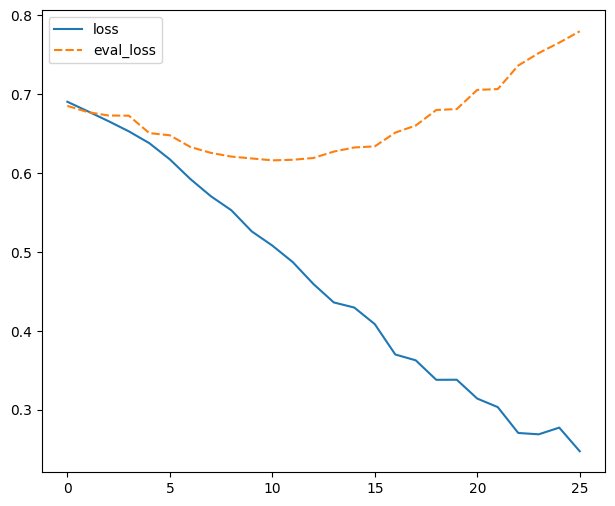

In [14]:
plot_loss_accuracy(mergedDf)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


balanced Accuracy: 0.6782167181282117
accuracy 0.675


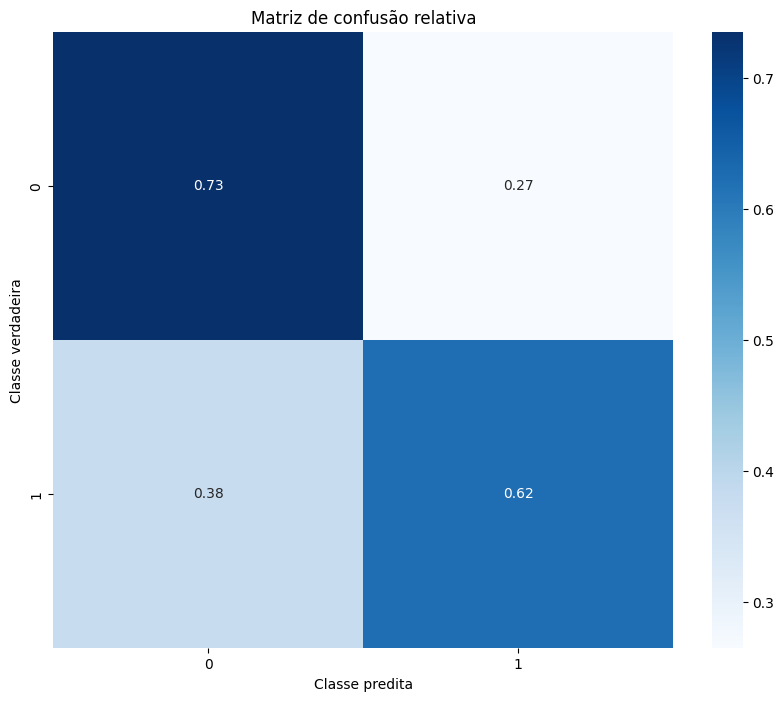

In [15]:
from transformers import pipeline
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer)

predictions = classifier(train_val_set["test"]["Review"], batch_size=16)


plot_confusion_matrix(train_val_set["test"], predictions)